In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib notebook

import numpyro
from numpyro.contrib.einstein import Stein, kernels
from numpyro.contrib.callbacks import Progbar
from numpyro.distributions import NormalMixture
from numpyro.infer import Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer.initialization import init_with_noise, init_to_value

In [2]:
rng_key = jax.random.PRNGKey(42)
num_iterations = 1500
target_dist = NormalMixture(jnp.array([1 / 3, 2 / 3]),
                            jnp.array([-2., 2.]), jnp.array([1., 1.]))

In [3]:
def model():
    numpyro.sample('x', target_dist)


guide = AutoDelta(model)
init_strategy = init_with_noise(init_to_value(values={'x': -10.}), noise_scale=1.0)

Rbf_Kernel:

Stein 1.9928: 100%|██████████| 1500/1500 [00:07<00:00, 207.01it/s]


Linear_Kernel:

Stein 2.1842: 100%|██████████| 1500/1500 [00:01<00:00, 1262.53it/s]


Random_Kernel:

Stein 2.0197: 100%|██████████| 1500/1500 [00:26<00:00, 56.37it/s]


Imq_Kernel:

Stein 1.9952: 100%|██████████| 1500/1500 [00:01<00:00, 933.01it/s] 


Matrix_Kernel:

Stein 2.0168: 100%|██████████| 1500/1500 [00:26<00:00, 56.57it/s]


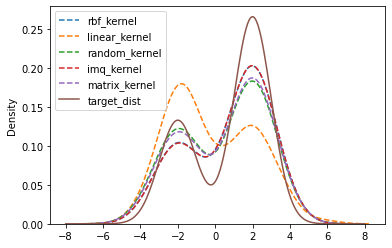

In [4]:
% matplotlib inline
kernels_fns = {'rbf_kernel': kernels.RBFKernel(),
               'linear_kernel': kernels.LinearKernel(),
               'random_kernel': kernels.RandomFeatureKernel(),
               'imq_kernel': kernels.IMQKernel(),
               'matrix_kernel': kernels.MixtureKernel([0.5, 0.5],
                                                      [kernels.LinearKernel(),
                                                       kernels.RandomFeatureKernel()])}
for label, kernel_fn in kernels_fns.items():
    print(label.title(), end=':')
    svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), Trace_ELBO(),
                 kernel_fn, init_strategy=init_strategy, num_particles=100)
    state, _ = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])
    sns.kdeplot(x=svgd.get_params(state)['x_auto_loc'], label=label, linestyle='dashed')

x = jnp.linspace(-8, 8., 200)
plt.plot(x, jnp.exp(target_dist.log_prob(x)), label='target_dist')
plt.legend()
plt.show()